### 作業目的: 使用樹型模型進行文章分類

本次作業主利用[Amazon Review data中的All Beauty](https://nijianmo.github.io/amazon/index.html)來進行review評價分類(文章分類)

資料中將review分為1,2,3,4,5分，而在這份作業，我們將評論改分為差評價、普通評價、優良評價(1,2-->1差評、3-->2普通評價、4,5-->3優良評價)

### 載入套件

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import os

# Current directory
print(os.getcwd())

# change directory
os.chdir('/content/drive/MyDrive/python_training/NLP100Days/day_28-Tree_Base_model_tool_practice/')
print(os.getcwd())

/content
/content/drive/MyDrive/python_training/NLP100Days/day_28-Tree_Base_model_tool_practice


In [2]:
import json
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.datasets import make_gaussian_quantiles
from sklearn.tree import plot_tree
import numpy as np

### 資料前處理
文本資料較為龐大，這裡我們取前10000筆資料來進行作業練習

In [3]:
#load json data
all_reviews = []
###<your code>###
with open('All_Beauty.json', 'r') as read_file:
    for review in read_file:
        all_reviews.append(json.loads(review))       
all_reviews[0]

{'asin': '0143026860',
 'overall': 1.0,
 'reviewText': 'great',
 'reviewTime': '02 19, 2015',
 'reviewerID': 'A1V6B6TNIC10QE',
 'reviewerName': 'theodore j bigham',
 'summary': 'One Star',
 'unixReviewTime': 1424304000,
 'verified': True}

In [4]:
#parse label(overall) and corpus(reviewText)
corpus = []
labels = []

for review in all_reviews[:10000]:
    if review.get("reviewText", False) and review.get("overall", False):
        corpus.append(review["reviewText"])
        labels.append(review["overall"])

##資料中將review分為1,2,3,4,5分，而在這份作業，
##我們將評論改分為差評價、普通評價、優良評價(1,2-->1差評、3-->2普通評價、4,5-->3優良評價)        
#transform labels: 1,2 --> 1 and 3 --> 2 and 4,5 --> 3
for i, label in enumerate(labels):
    if label == 1 or label == 2:
        labels[i] = 1
    elif label == 3:
        labels[i] = 2
    else:
        labels[i] = 3

#preprocessing data

In [5]:
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords

import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:

# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

## 創建Lemmatizer
lemmatizer = WordNetLemmatizer() 
def get_wordnet_pos(word):
    """將pos_tag結果mapping到lemmatizer中pos的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def clean_content(X):
    corpustext =[]
    # remove non-alphabet characters
    #pattern = r'[^a-zA-Z]'

    #remove email address, punctuations, and change line symbol(\n)
    pattern = r'\S*@\S*|\\n|[^a-zA-Z0-9 ]'

    #for i, sub_corpus in enumerate(X):
    #  corpus_split = [w for w in re.sub(pattern, " ", sub_corpus).split(" ") if w != ""]
    #  corpus_split = " ".join(corpus_split)
    #  corpus_split = corpus_split.lower()
    #  corpustext.append(corpus_split)

    X_clean = [re.sub(pattern,' ', x).lower() for x in X]

    # tokenize
    X_word_tokenize = [nltk.word_tokenize(x) for x in X_clean] #X_clean / corpustext
    # stopwords_lemmatizer
    X_stopwords_lemmatizer = []
    stop_words = set(stopwords.words('english'))
    for content in X_word_tokenize:
        content_clean = []
        for word in content:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                content_clean.append(word)
        X_stopwords_lemmatizer.append(content_clean)
    
    X_output = [' '.join(x) for x in X_stopwords_lemmatizer]
    
    return X_output
  

In [7]:
#preprocessing data
#remove email address, punctuations, and change line symbol(\n)

###<your code>###
corpus_clean = clean_content(corpus)
corpus_clean[:3]


['great',
 'husband want reading negro baseball great addition library library haveinformation book start tthank',
 'book informative cover aspect game']

In [8]:
#split corpus and label into train and test
###<your code>###
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(corpus_clean, labels, test_size = 0.2, random_state=0)

len(x_train), len(x_test), len(y_train), len(y_test)

(7996, 1999, 7996, 1999)

In [9]:
#change corpus into vector
#you can use tfidf or BoW here

###<your code>###
# max_df=0.5 單詞如果在50%以上的文件出現就不考慮
# min_df=5 單詞如果出現次數少於5次就不考慮, min_df=0.1 單詞如果在10%以下的文件中出現就不考慮
vectorizer = TfidfVectorizer() 
## 用X_train來build 字典，字數還有document 數量
vectorizer.fit(x_train)

## 得到tfidf vector
#transform training and testing corpus into vector form
x_train = vectorizer.transform(x_train).toarray()
x_test = vectorizer.transform(x_test).toarray()


print(x_test)
print('\n')
print('單詞對應index: \n{}'.format(vectorizer.vocabulary_))



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


單詞對應index: 
{'great': 3132, 'deal': 1937, 'good': 3080, 'price': 5109, 'nice': 4467, 'strong': 6390, 'material': 4146, 'would': 7418, 'buy': 1250, 'many': 4106, 'need': 4431, 'fast': 2693, 'delivery': 2007, 'instal': 3590, 'hop': 3362, 'last': 3836, 'break': 1135, 'work': 7400, 'update': 7063, 'review': 5598, 'get': 3021, 'pack': 4730, 'box': 1107, 'husband': 3415, 'value': 7112, 'cheaper': 1396, 'anywhere': 622, 'else': 2406, 'see': 5838, 'far': 2687, 'product': 5144, 'shipping': 5967, 'quality': 5252, 'finish': 2770, 'heavy': 3282, 'long': 3981, 'enough': 2448, 'merkur': 4205, '23c': 114, 'well': 7291, 'make': 4068, 'stable': 6290, 'provide': 5198, 'brush': 1187, 'place': 4936, 'dry': 2293, 'properly': 5179, 'stylish': 6416, 'appearance': 638, 'item': 3679, 'carry': 1323, 'pop': 5007, 'shop': 5977, 'solid': 6165, 'recommend': 54

In [10]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

### 訓練與預測

In [11]:
#build classification model (decision tree, random forest, or adaboost)
#start training
###<your code>###
#建立決策樹模型
decision_tree_cls = DecisionTreeClassifier(criterion='entropy', max_depth=3,
              min_samples_split=10, min_samples_leaf=5)

#使用決策樹模型進行訓練
decision_tree_cls.fit(x_train, y_train)
#len(x_train), len(x_test), len(y_train), len(y_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [12]:
#start inference

#以訓練好的決策樹進行預測
y_pred = decision_tree_cls.predict(x_test)


In [13]:
#calculate accuracy
###<your code>###
# 也可以使用DecisionTreeClassifier內建的方法來計算準確度
print(f"Accuracy: {decision_tree_cls.score(x_test,y_test)}")

# 查看決策樹深度與終端節點個數
print(f"Depth: {decision_tree_cls.get_depth()}, Number of leaves: {decision_tree_cls.get_n_leaves()}")

Accuracy: 0.9069534767383692
Depth: 3, Number of leaves: 8


In [14]:
#calculate confusion matrix, precision, recall, and f1-score
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.27      0.39       134
           2       0.00      0.00      0.00        73
           3       0.91      0.99      0.95      1792

    accuracy                           0.91      1999
   macro avg       0.53      0.42      0.45      1999
weighted avg       0.86      0.91      0.88      1999

[[  36    0   98]
 [   2    0   71]
 [  15    0 1777]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# 先前的課程中提到，我們可以透過feature被使用來分割的次數得知feature的重要程度
# 我們可以透過feature_importance_來得到重要程度的值，且所有feature的重要程度合為1

print("Importance:")
print(f"feature: {decision_tree_cls.feature_importances_}")
print(f"feature_1: {decision_tree_cls.feature_importances_[0]}")
print(f"feature_2: {decision_tree_cls.feature_importances_[1]}")
print(f"Total: {decision_tree_cls.feature_importances_.sum()}")

Importance:
feature: [0. 0. 0. ... 0. 0. 0.]
feature_1: 0.0
feature_2: 0.0
Total: 1.0


[Text(167.4, 190.26, 'X[5587] <= 0.075\nentropy = 0.593\nsamples = 7996\nvalue = [551, 307, 7138]'),
 Text(83.7, 135.9, 'X[7245] <= 0.089\nentropy = 0.564\nsamples = 7906\nvalue = [490, 300, 7116]'),
 Text(41.85, 81.53999999999999, 'X[6354] <= 0.106\nentropy = 0.545\nsamples = 7847\nvalue = [446, 299, 7102]'),
 Text(20.925, 27.180000000000007, 'entropy = 0.522\nsamples = 7768\nvalue = [400, 293, 7075]'),
 Text(62.775000000000006, 27.180000000000007, 'entropy = 1.266\nsamples = 79\nvalue = [46, 6, 27]'),
 Text(125.55000000000001, 81.53999999999999, 'X[5109] <= 0.058\nentropy = 0.908\nsamples = 59\nvalue = [44, 1, 14]'),
 Text(104.625, 27.180000000000007, 'entropy = 0.787\nsamples = 53\nvalue = [43, 1, 9]'),
 Text(146.475, 27.180000000000007, 'entropy = 0.65\nsamples = 6\nvalue = [1, 0, 5]'),
 Text(251.10000000000002, 135.9, 'X[1187] <= 0.035\nentropy = 1.164\nsamples = 90\nvalue = [61, 7, 22]'),
 Text(209.25, 81.53999999999999, 'X[5587] <= 0.19\nentropy = 0.889\nsamples = 72\nvalue = [5

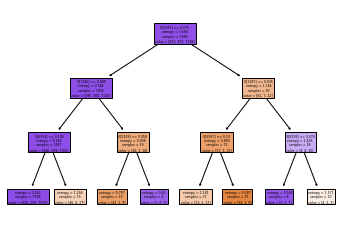

In [20]:
# 透過sklearn.tree.plot_tree，可以視覺化決策樹決策過程
plot_tree(decision_tree_cls, filled=True)

由上述資訊可以發現, 模型在好評的準確度高(precision, recall都高), 而在差評的部分表現較不理想, 在普通評價的部分大部分跟差評搞混,
同學可以試著學習到的各種方法來提升模型的表現